In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [29]:
# 1. Load daily data and resample to weekly means (Sun-anchored)

df = pd.read_csv("../data/processed/water_levels_daily.csv", parse_dates=["timestamp"])
weekly = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

# keep as single-column frame for convenience
weekly_df = weekly.to_frame(name="value")

# ------------------------------------------------------------------
# 2. Dynamic cap – same helper as in the SARIMA notebook -------------
anchor_template = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            yr = y0 if mon >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mon, day), lvl))
            except ValueError:
                # fallback for Feb-29 on non-leap years
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]
    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(weekly_df.index)

# ------------------------------------------------------------------
# 3. Train / validation / test split ----------------------------------
train_df       = weekly_df.loc[:"2017-12-31"]
validation_df  = weekly_df.loc["2018-01-01":"2020-12-31"]
# test_df      = weekly_df.loc["2021-01-01":]   # kept for later

# ------------------------------------------------------------------
# 4. Scaling – fit only on training -----------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ------------------------------------------------------------------
# 5. Helper to build lookback / horizon windows -----------------------
LOOKBACK = 52           # weeks history
HORIZON  = 4            # 4-week ahead target


def make_windows(arr, lookback=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback:i, 0])
        y.append(arr[i + horizon - 1, 0])
    return np.array(X), np.array(y)

# ---------------- Training windows -----------------------------------
X_train, y_train = make_windows(train_scaled)

# ---------------- Validation windows (corrected) ---------------------
PAD_LEN = LOOKBACK + HORIZON - 1   # History required before val starts
padding   = train_scaled[-PAD_LEN:]              # last PAD_LEN train rows
val_block = np.vstack([padding, validation_scaled])

X_val, y_val = make_windows(val_block)

# validation_pred_dates should now match validation_df.index exactly
# Verify the length: should be len(validation_df)
assert len(X_val) == len(validation_df), "Length mismatch!"

validation_pred_dates = validation_df.index # Assign the full index

# reshape to Keras 3-D format
X_train = X_train.reshape((-1, LOOKBACK, 1)).astype("float32")
X_val   = X_val  .reshape((-1, LOOKBACK, 1)).astype("float32")

# ------------------------------------------------------------------
# 6. LSTM model (identical to user baseline) --------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=2,
)

Length of validation_df: 156
Length of X_val: 156
Length of y_val: 156
Epoch 1/100


c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 - 2s - 74ms/step - loss: 0.1098 - val_loss: 0.1271
Epoch 2/100
28/28 - 0s - 16ms/step - loss: 0.0620 - val_loss: 0.0982
Epoch 3/100
28/28 - 0s - 16ms/step - loss: 0.0457 - val_loss: 0.0566
Epoch 4/100
28/28 - 0s - 16ms/step - loss: 0.0318 - val_loss: 0.0399
Epoch 5/100
28/28 - 0s - 16ms/step - loss: 0.0297 - val_loss: 0.0350
Epoch 6/100
28/28 - 0s - 17ms/step - loss: 0.0293 - val_loss: 0.0357
Epoch 7/100
28/28 - 0s - 17ms/step - loss: 0.0268 - val_loss: 0.0365
Epoch 8/100
28/28 - 0s - 16ms/step - loss: 0.0273 - val_loss: 0.0321
Epoch 9/100
28/28 - 0s - 16ms/step - loss: 0.0258 - val_loss: 0.0304
Epoch 10/100
28/28 - 0s - 16ms/step - loss: 0.0255 - val_loss: 0.0287
Epoch 11/100
28/28 - 0s - 16ms/step - loss: 0.0243 - val_loss: 0.0289
Epoch 12/100
28/28 - 0s - 16ms/step - loss: 0.0243 - val_loss: 0.0398
Epoch 13/100
28/28 - 0s - 16ms/step - loss: 0.0235 - val_loss: 0.0230
Epoch 14/100
28/28 - 0s - 16ms/step - loss: 0.0228 - val_loss: 0.0214
Epoch 15/100
28/28 - 0s - 16ms/step - los

In [30]:
# 7. Forecast on validation period ------------------------------------
validation_predictions = model.predict(X_val, verbose=0).flatten()
validation_actual      = y_val

# inverse‑transform ----------------------------------------------------
validation_predictions = scaler.inverse_transform(validation_predictions.reshape(-1, 1)).flatten()
validation_actual      = scaler.inverse_transform(validation_actual.reshape(-1, 1)).flatten()

# capping --------------------------------------------------------------
MIN_VAL = 205.0
cap_val = max_level.loc[validation_pred_dates].values
predictions_capped = np.maximum(validation_predictions, MIN_VAL)
predictions_final  = np.minimum(predictions_capped, cap_val)

# ------------------------------------------------------------------
# 8. Metrics -----------------------------------------------------------
validation_results = pd.DataFrame({
    "Actual":    validation_actual,
    "Predicted": predictions_final,
}, index=validation_pred_dates)

rmse = np.sqrt(mean_squared_error(validation_results["Actual"], validation_results["Predicted"]))
mae  = mean_absolute_error(validation_results["Actual"], validation_results["Predicted"])

metrics_df = pd.DataFrame({"Metric": ["MAE", "RMSE"], "Value": [mae, rmse]})

metrics_df

,Metric,Value
0,MAE,2.243778
1,RMSE,2.875475


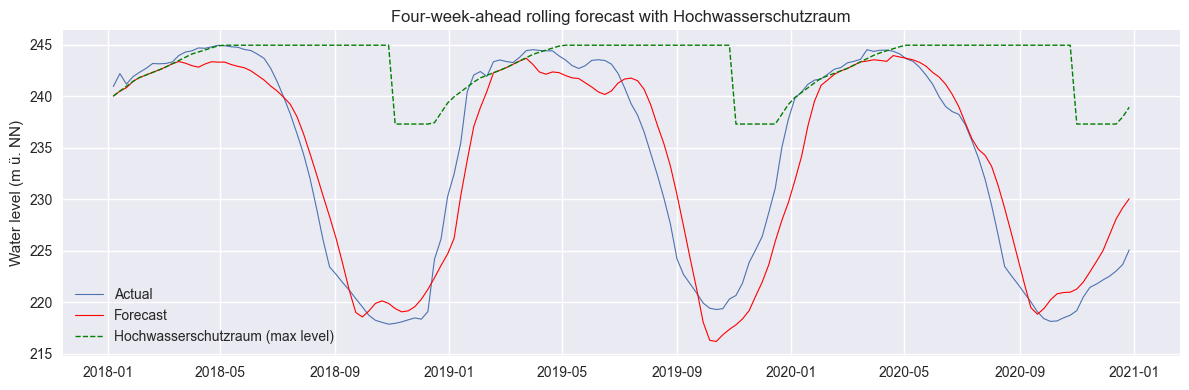

In [31]:
fig, ax = plt.subplots(figsize=(12,4))

# 1) plot actuals & forecasts
ax.plot(validation_results.index, validation_results['Actual'], label='Actual', lw=.8)
ax.plot(validation_results.index, validation_results['Predicted'], label='Forecast', color='red', lw=.8)

# 2) plot the buffer‐level (max allowed) as a dashed line
ax.plot(max_level.loc[validation_pred_dates],
        label='Hochwasserschutzraum (max level)',
        color='green', linestyle='--', lw=1)


ax.set_title("Four-week-ahead rolling forecast with Hochwasserschutzraum")
ax.set_ylabel("Water level (m ü. NN)")
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()